In [2]:
import os
os.environ['MUJOCO_GL'] = 'egl'
os.environ["MUJOCO_EGL_DEVICE_ID"] = "0"
from typing import Sequence, List, Any, NamedTuple, Tuple, Optional
from collections import namedtuple

import sys
from os.path import dirname, abspath
project_folder = dirname(dirname(abspath("rodent.py")))
sys.path.insert(1, project_folder)

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf


from stage1_rodent_task import rodent_env,_CONTROL_TIMESTEP,SITE_NAMES

import pandas as pd
import argparse
import random
import time
from distutils.util import strtobool
import gymnasium as gym
import numpy as np

import argparse
import os
import random
import time
from distutils.util import strtobool
import gymnasium as gym
import numpy as np


import moviepy.video.io.ImageSequenceClip
import gymnasium as gym

from matplotlib import pyplot as plt
import numpy as np
import csv


#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML



# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import PIL.Image
from inverse_kinematics import qpos_from_site_xpos
import quaternions
import pickle 
from ipywidgets import Video




/home/anirudh/anaconda3/envs/dmc/lib/python3.9/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


pygame 2.5.2 (SDL 2.28.2, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/anirudh/anaconda3/envs/dmc/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [3]:
dataset_num = 2
dataset_folder  = project_folder + '/dataset/' + str(dataset_num) + '/'
local_dataset_folder = '/home/anirudh/p6/dataset/' + str(dataset_num) + '/'
il_frames_save_folder = local_dataset_folder + 'il_frames/'
increase_freq = 1
initial_repeat = 0

In [4]:


label_file =  dataset_folder+"data3D.csv"
output_new_clip_end_file_path = dataset_folder+"lengths.npy"
site_index_to_delete = [9,13]
frame_start_stop_path_csv = dataset_folder + 'clip_frames.csv'
start_end_clip_csv = np.loadtxt(frame_start_stop_path_csv, delimiter=',', dtype='int64', skiprows=1)
nclips = start_end_clip_csv.shape[0]*2



In [5]:
def swapLR(idx,array):
    t = np.array(array,copy=True)
    array[:,idx[0],:] = array[:,idx[1],:]
    array[:,idx[1],:] = t[:,idx[0],:]
    return array

def csv_reader_jarvis3d(file_name, num_keypoints):
    """
    Return keypoints as numpy array [frames, num_keypoints, 3]
    """
    all_keypoints = []
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0 or line_count == 1:
                #print(f'{", ".join(row)}')
                line_count += 1
            else:
                keypoints = [float(x) for x in row]
                keypoints = np.asarray(keypoints)
                keypoints = keypoints.reshape([num_keypoints, 4])[:,:3]
                keypoints = np.delete(keypoints,site_index_to_delete,0)
                all_keypoints.append(keypoints)
                line_count += 1
    all_keypoints = np.asarray(all_keypoints)
    return all_keypoints

keypoints = csv_reader_jarvis3d(label_file, 20)


new_keypoints = np.zeros(keypoints.shape)
for frames in range(keypoints.shape[0]):
    for keypoint_sites in range(keypoints.shape[1]):
        original_kp = keypoints[frames][keypoint_sites]
        new_x = (original_kp[0]/1000)*(-1)*(1)
        new_y = (original_kp[1]/1000)*(-1)*(1)
        new_z = (original_kp[2]/1000)*(1)*(1)
        new_keypoints[frames][keypoint_sites] = [new_x,new_y,new_z]

filtered_keypoints = np.zeros((0,new_keypoints.shape[1],new_keypoints.shape[2]))
for i in range(start_end_clip_csv.shape[0]):
    start_frame = start_end_clip_csv[i][0]
    end_frame = start_end_clip_csv[i][1]
    temp = new_keypoints[start_frame:end_frame]
    filtered_keypoints = np.concatenate((filtered_keypoints,temp))
new_keypoints = filtered_keypoints


    

mirror = np.array(new_keypoints, copy=True)  
mirror[:,:,1] = mirror[:,:,1] *-1
mirror = swapLR((1,2),mirror)
mirror = swapLR((6,9),mirror)
mirror = swapLR((7,10),mirror)
mirror = swapLR((8,11),mirror)
mirror = swapLR((12,15),mirror)
mirror = swapLR((13,16),mirror)
mirror = swapLR((14,17),mirror)

training_data = np.concatenate((new_keypoints,mirror))
print(training_data.shape, "this has training data + mirror data") 





(19366, 18, 3) this has training data + mirror data


In [ ]:

clip_lengths = start_end_clip_csv[:,1] - start_end_clip_csv[:,0]
clip_lengths = np.concatenate((clip_lengths,clip_lengths)) # for mirror data
clip_ends = []
sum_temp = 0
for i in clip_lengths:
    sum_temp+=i
    clip_ends.append(sum_temp)
clip_ends = np.array(clip_ends)
clip_lengths_and_ends = np.concatenate(([clip_lengths],[clip_ends]),axis=0).T 
print(clip_lengths_and_ends.shape, "this has clip lengths(column 0) and clip end index(column 1)")
assert training_data.shape[0] == clip_lengths_and_ends[-1][1], "training data and clip ends do not match"


In [ ]:
clip_arrays = np.split(training_data, np.cumsum(clip_lengths_and_ends[:,0])[:-1])

In [ ]:
len(clip_arrays)

In [ ]:
all_new_clips = []
all_new_clip_lengths = []
for k in range(nclips):
    temp_clip = clip_arrays[k]
    all_sites_hf_clips = []
    for site in range(temp_clip.shape[1]):
        site_clip = temp_clip[:,site,:]
        higher_freq_clip = np.empty((0,3))
        for i in range(site_clip.shape[0]-1):
            higher_freq_clip = np.concatenate((higher_freq_clip,np.linspace(site_clip[i],site_clip[i+1],increase_freq,endpoint=False)),axis=0)
        higher_freq_clip = np.concatenate((higher_freq_clip,site_clip[-1].reshape(1,3)),axis=0)
        higher_freq_clip = np.expand_dims(higher_freq_clip,axis=1)
        all_sites_hf_clips.append(higher_freq_clip)
    all_sites_hf_clips = np.concatenate(all_sites_hf_clips,axis=1)
    for repeat in range(initial_repeat):
        all_sites_hf_clips = np.concatenate(([all_sites_hf_clips[0]],all_sites_hf_clips),axis=0)
    all_new_clip_lengths.append(all_sites_hf_clips.shape[0])
    all_new_clips.append(all_sites_hf_clips)
all_new_clips = np.concatenate(all_new_clips,axis=0)
print(all_new_clips.shape, "this has all the training data with increased frequency")

final_shape = 0
for old_cliplen in clip_lengths_and_ends[:nclips,0]:
    final_shape+=(old_cliplen-1)*increase_freq + 1+ initial_repeat

assert sum(all_new_clip_lengths) == final_shape , "error"

In [ ]:
sum_temp = 0
new_clip_ends = []
for i in all_new_clip_lengths:
    sum_temp+=i
    new_clip_ends.append(sum_temp)
new_clip_ends = np.array(new_clip_ends)
new_clip_lengths_ends = np.concatenate(([all_new_clip_lengths],[new_clip_ends]),axis=0).T
print(new_clip_lengths_ends.shape, "this has all new clip lengths(column 0) and clip end index(column 1)")    
np.save(output_new_clip_end_file_path,new_clip_lengths_ends)


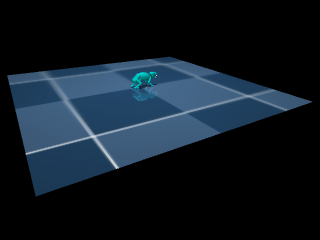

In [4]:
env = rodent_env(add_ghost=False,add_ball=False,)
env.reset()
PIL.Image.fromarray(env.physics.render(camera_id=7))


In [ ]:
# This namedtuple must be created outside of the function
# `get_full_data_from_ik_frame` to be picklable.
TimestepData = namedtuple(
    'TimestepData', ['qpos', 'qvel', 'root2site',
                     'joint_quat', 'site_xpos', 'xvel'])

joint_names = [env.physics.model.id2name(j, 'joint')
                         for j in range(env.physics.model.njnt)]

site_names  =  SITE_NAMES
inverse_kinemtics_site_names = site_names.copy()
site_index_to_delete.sort(reverse=True)
for index in site_index_to_delete:
    del inverse_kinemtics_site_names[index]
    

In [ ]:
def get_full_data_from_ik_frame(
        physics: 'mjcf.Physics',
        qpos_prev: Optional[np.ndarray] = None,
        site_xpos_prev: Optional[np.ndarray] = None,
        dt: Optional[float] = None,
        walker: str = 'walker/',
        ) -> NamedTuple:
    """Uses partial IK state information to generate all data needed
    for imitation learning training.

    Everything (except root qpos, root qvel, root quat) is calculated
    in local egocentric reference frame (NOT world reference frame).

    To calculate the returned values, the following quantities from
    `physics.data` are used: qpos, xpos, xquat, site_xpos, xaxis.

    Requires the following namedtuple (must be created outside this function
    so it can be picklable):
    TimestepData = namedtuple(
        'TimestepData',
        ['qpos', 'qvel', 'root2site', 'joint_quat', 'site_xpos', 'xvel'])

    Args:
        physics: Instance of mjcf.Physics class.
        qpos_prev: `qpos` from previous timestep to use in finite differences.
            Not used in the first timestep and an array of zeros is returned
            for `qvel`.
        site_xpos_prev: `site_xpos` from previous timestep. Not used in the
            first timestep and an array of zeros is returned for `xvel`.
        dt: Time interval to use for finite difference calculation.
            Should match the timestep of the underlying IK qpos data.
            Not used in the first timestep.
        walker: Name of walker in physics.data.

    Returns:
        qpos: Joint angles, (nq,).
        qvel: Joint angle velocities, (nv,).
            NOTE: nq is not necessarily equal nv. In general, nq >= nv.
        root2site: Egocentric root-to-site vectors for all sites, (nsite, 3).
        joint_quat: Joint orientation quaternions, skipping the root joint,
            shape (njnt-1, 3). The root joint quaternion is included
            automatically in qpos[3:7].
        site_xpos: Cartesian positions of all sites in local frame (nsite, 3).
        xvel: Cartesian velocity for all sites in local frame (nsite, 3).
    """
    # Current qpos.
    qpos = physics.data.qpos.copy()

    # All qvel (if `qpos_prev` is provided).
    qvel = np.zeros(physics.model.nv)
    if qpos_prev is not None:
        mjlib.mj_differentiatePos(
            physics.model.ptr, qvel,
            dt, qpos_prev, qpos)  # Finite diffs.

    # Egocentric root-to-site vectors for all sites in local coordinates.
    root_xpos = physics.named.data.xpos[walker].copy()
    root_quat = physics.named.data.xquat[walker].copy()
    site_xpos = physics.named.data.site_xpos[site_names].copy()
    root2site = quaternions.get_egocentric_vec(
                    root_xpos, site_xpos, root_quat).copy()

    # Joint orientation quaternions in local egocentric
    # reference frame (NOT world frame).
    xaxis1 = physics.data.xaxis[1:].copy()  # (njnt-1, 3)
    xaxis1 = quaternions.rotate_vec_with_quat(
        xaxis1, quaternions.reciprocal_quat(root_quat))
    qpos7 = physics.data.qpos[7:].copy()  # (njnt-1,)
    joint_quat = quaternions.joint_orientation_quat(xaxis1, qpos7).copy()  # (njnt-1, 4)

    # Cartesian site positions in local egocentric
    # reference frame (NOT world frame).
    site_xpos = physics.named.data.site_xpos[site_names].copy()  # (n_sites, 3)
    #site_xpos[:, :] -= root_xpos[None, :]
    #site_xpos = quaternions.rotate_vec_with_quat(site_xpos, quaternions.reciprocal_quat(root_quat))

    # Cartesian velocities xvel in local egocentric
    # reference frame (NOT world frame) for all sites.
    if site_xpos_prev is not None:
        xvel = (site_xpos - site_xpos_prev) / dt
    else:
        xvel = np.zeros((site_xpos.shape[0], 3))

    return TimestepData(qpos, qvel, root2site, joint_quat, site_xpos, xvel)


In [ ]:
len(all_new_clips)

In [ ]:
nq = env.physics.model.nq
nv = env.physics.model.nv
nsite = 20
njnt = env.physics.model.njnt
full_data = []

clip_id = 0
env.reset()
first_frame_of_clip = True

for f in range(len(all_new_clips)):

    if f==new_clip_lengths_ends[clip_id][1]:
        first_frame_of_clip = True
        clip_id+=1


    if first_frame_of_clip:
        env.reset()

    ikres_frame = qpos_from_site_xpos(physics=env.physics,
                                            site_names=inverse_kinemtics_site_names,
                                            target_xpos=all_new_clips[f],
                                            joint_names=joint_names,
                                            reg_strength=1e-4,
                                            inplace=True)  
    print(f,ikres_frame.success)

    if first_frame_of_clip:
        ik_data_extract = get_full_data_from_ik_frame(env.physics)
    else:
        ik_data_extract  = get_full_data_from_ik_frame(
            env.physics,
            qpos_prev=full_data[-1].qpos,
            site_xpos_prev=full_data[-1].site_xpos,
            dt=_CONTROL_TIMESTEP)
        

    full_data.append(ik_data_extract)

    #img = PIL.Image.fromarray(env.physics.render(camera_id=4,height=2200,width=3208))
    #img.save(il_frames_save_folder+str(f)+'.png')

    first_frame_of_clip = False

In [ ]:
# === Parse full_data.
n_frames = len(full_data)

qpos = np.zeros((n_frames, nq))
qvel = np.zeros((n_frames, nv))
root2site = np.zeros((n_frames, nsite, 3))
joint_quat = np.zeros((n_frames, njnt-1, 4))
site_xpos = np.zeros((n_frames, nsite, 3))
xvel = np.zeros((n_frames, nsite, 3))

for i in range(len(full_data)):
    qpos[i, :] = full_data[i].qpos
    qvel[i, :] = full_data[i].qvel
    root2site[i, :, :] = full_data[i].root2site
    joint_quat[i, :, :] = full_data[i].joint_quat
    site_xpos[i, :, :] = full_data[i].site_xpos
    xvel[i, :, :] = full_data[i].xvel

snippet_full_data = {
        'qpos': qpos.astype(np.float32),  # (n_frames, nq)
        'qvel': qvel.astype(np.float32),  # (n_frames, nv)
        'root2site': root2site.astype(np.float32),  # (n_frames, nsite, 3)
        'joint_quat': joint_quat.astype(np.float32),  # (n_frames, njnt-1, 4)
        'site_xpos': site_xpos.astype(np.float32),  # (n_frames, nsite, 3)
        'xvel': xvel.astype(np.float32),  # (n_frames, nsite, 3)
    }

with open(dataset_folder+'imitation_train_data.pkl', 'wb') as f:
    pickle.dump(snippet_full_data, f)

In [ ]:
env.reset()
frames = []
with open(dataset_folder+'imitation_train_data.pkl', 'rb') as f:
	test_data = pickle.load(f)
qpos_data = test_data['qpos']

In [5]:

env.reset()
frames = []
with open(dataset_folder+'imitation_train_data.pkl', 'rb') as f:
	test_data = pickle.load(f)
qpos_data = test_data['qpos']
env.reset()    

for i in range(qpos_data.shape[0]):
    with env.physics.reset_context():
        env.physics.data.qpos = qpos_data[i].copy()


    img =  env.physics.render(camera_id=7,height=1000,width=1500)
    frames.append(img)

    #img = PIL.Image.fromarray(env.physics.render(camera_id=3,height=220,width=320,scene_option=scene_option))
    #img.save('../il_data_frames/'+str(i)+'.png')


In [8]:
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frames, fps=50)
clip.write_videofile(local_dataset_folder+'ik.mp4')
Video.from_file(local_dataset_folder+'ik.mp4', width=1000, height=1500)

Moviepy - Building video /home/anirudh/p6/dataset/2/ik.mp4.
Moviepy - Writing video /home/anirudh/p6/dataset/2/ik.mp4



Moviepy - Done !
Moviepy - video ready /home/anirudh/p6/dataset/2/ik.mp4


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...', height='1500', wi…

In [ ]:
new_clip_lengths_ends = np.load(output_new_clip_end_file_path)
clip_arrays = np.split(qpos_data, np.cumsum(new_clip_lengths_ends[:,0])[:-1])
ik_for_comparision = np.concatenate([arr[initial_repeat:][::increase_freq] for arr in clip_arrays],axis=0)
assert ik_for_comparision.shape[0] == clip_lengths_and_ends[nclips-1][1], "ik_for_comparision and original_clip_len do not match"
ik_for_comparision = {'qpos': ik_for_comparision.astype(np.float32)}

In [ ]:
with open('../dataset/imitation_train_data_for_comparision.pkl', 'wb') as f:
    pickle.dump(ik_for_comparision, f)

In [ ]:
# After seeing the IK images , select the start frames of each clip ( so that its a stable start frame)

In [ ]:

len_arr  = np.load('../dataset/all_lengths.npy')  
start_points = [0,205,386,489,654,694,783,915,1089,1310,1528,1798,1889,2014,2082,2159,2243,2397,2565,2800,3058,3155,3338,3401,3520,3699,3834,4053,4165,4370,4551,4654,4819,4859,4948,5080,5254,5475,5693,5963,6054,6179,6247,6324,6408,6562,6730,6965,7223,7320,7503,7566,7685,7864,7999,8218]
start_points = np.array(start_points)
len_arr = np.concatenate((len_arr,start_points.reshape(-1,1)),axis=1)
print(len_arr.shape, "this has all the lengths and start points(3rd column)")
np.save('../dataset/all_lengths_final.npy',len_arr)
print(len_arr)